In [37]:
# import sys
# !{sys.executable} -m pip install MacTeX

In [38]:
# classical gym 
import gym
import numpy as np
import time
import matplotlib.pyplot as plt 

In [39]:
"""
Disclaimer: By Mirna & Reem
This code was captured from Alexsander Haber Work on the same topic .. The original code 
fragment had more details that was not required here in the quiz..for example : 
simulateRandomPolicy to compare against the simulateLearnedPolicy..There is an important note
here to be considered : in the takeAction(): 
The condition implying that we don't use epsilon greedy algorithm before the 100th episode is
there for the fact that without it the final plot will show extreme fluctuation and will result 
in meaningless outcomes and for that I have attached a result graph ( to be viewed versus 
the final output ) and we saved it (convergenceWithoutExploration.jpg)
There are some NumPy functions that we searched :
np.linspace() -> Return evenly spaced numbers over a specified interval.
np.digitize() -> Return the indices of the bins to which each value in input array belongs.

"""
class Q:    
    def __init__(self,env,numberEpisodes,numberOfBins,lowerBounds,upperBounds,alpha=0.1,gamma=0.9,epsilon=0.05):    
        self.env = env
        self.alpha = alpha
        self.gamma = gamma 
        self.epsilon = epsilon 
        self.actionNumber = env.action_space.n 
        self.numberEpisodes = numberEpisodes
        self.numberOfBins = numberOfBins
        self.lowerBounds = lowerBounds 
        self.upperBounds = upperBounds  
        # this list stores sum of rewards in every learning episode
        self.sumRewardsEpisode=[]   
        # this matrix is the action value function matrix 
        self.Qmatrix=np.random.uniform(low=0, high=1, size=(numberOfBins[0],numberOfBins[1],numberOfBins[2],numberOfBins[3],self.actionNumber))
        self.cartPosition_bins_bounds=np.linspace(self.lowerBounds[0],self.upperBounds[0],self.numberOfBins[0])
        self.cartVelocity_bins_bounds=np.linspace(self.lowerBounds[1],self.upperBounds[1],self.numberOfBins[1])
        self.poleAngle_bins_bounds=np.linspace(self.lowerBounds[2],self.upperBounds[2],self.numberOfBins[2])
        self.poleAngleVelocity_bins_bounds=np.linspace(self.lowerBounds[3],self.upperBounds[3],self.numberOfBins[3])
    def returnIndexState(self,state):
        index_position = np.maximum(np.digitize(state[0],self.cartPosition_bins_bounds)-1,0)
        index_velocity = np.maximum(np.digitize(state[1],self.cartVelocity_bins_bounds)-1,0)
        index_angle = np.maximum(np.digitize(state[2],self.poleAngle_bins_bounds)-1,0)
        index_angularVelocity = np.maximum(np.digitize(state[3],self.poleAngleVelocity_bins_bounds)-1,0)
        return tuple([index_position,index_velocity,index_angle,index_angularVelocity])   
    def selectAction(self,state,episodeNum):               
        # Returns a random real number in the half-open interval [0.0, 1.0)
        # this number is used for the epsilon greedy approach
        if episodeNum<100:
            return np.random.choice(self.actionNumber)   
        randomNumber = np.random.random()  
        if randomNumber < self.epsilon:
            return np.random.choice(self.actionNumber)            
        else:    
            return np.random.choice(np.where(self.Qmatrix[self.returnIndexState(state)]==np.max(self.Qmatrix[self.returnIndexState(state)]))[0])
            # here we need to return the minimum index since it can happen
            # that there are several identical maximal entries
            # that is why we need to have np.random.choice(np.where(a==np.max(a))[0])
            # note that zero has to be added here since np.where() returns a tuple
    def simulateEpisodes(self):
        # here we loop through the episodes
        for indexEpisode in range(self.numberEpisodes):         
            # list that stores rewards per episode - this is necessary for keeping track of convergence 
            rewardsEpisode=[]        
            # reset the environment at the beginning of every episode
            (stateS,_)=self.env.reset()
            stateS=list(stateS)
            #print("Simulating episode {}".format(indexEpisode))     
            # here we step from one state to another
            # this will loop until a terminal state is reached
            terminalState=False
            while not terminalState:
                # return a discretized index of the state   
                stateSIndex=self.returnIndexState(stateS)    
                # select an action on the basis of the current state, denoted by stateS
                actionA = self.selectAction(stateS,indexEpisode)
                (stateSprime, reward, terminalState,_,_) = self.env.step(actionA)          
                #observe reward and next state
                rewardsEpisode.append(reward)
                stateSprime=list(stateSprime)
                stateSprimeIndex=self.returnIndexState(stateSprime)
                # return the max value, we do not need actionAprime...
                QmaxPrime=np.max(self.Qmatrix[stateSprimeIndex])
                #Update Q-table value
                if not terminalState:
                    # stateS+(actionA,) - we use this notation to append the tuples
                    # for example, for stateS=(0,0,0,1) and actionA=(1,0)
                    # we have stateS+(actionA,)=(0,0,0,1,0)
                    error=reward+self.gamma*QmaxPrime-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                else:
                    # in the terminal state, we have Qmatrix[stateSprime,actionAprime]=0 
                    error=reward-self.Qmatrix[stateSIndex+(actionA,)]
                    self.Qmatrix[stateSIndex+(actionA,)]=self.Qmatrix[stateSIndex+(actionA,)]+self.alpha*error
                # set the current state to the next state                    
                stateS=stateSprime      
            #print("Sum of rewards {}".format(np.sum(rewardsEpisode)))        
            self.sumRewardsEpisode.append(np.sum(rewardsEpisode))

    # OUTPUT: 
    # env1 - created Cart Pole environment
    # obtainedRewards - a list of obtained rewards during time steps of a single episode
    
    # simulate the final learned optimal policy
    def simulateLearnedPolicy(self):
        env1=gym.make('CartPole-v1',render_mode='human')
        (currentState,_)=env1.reset()
        env1.render()
        timeSteps=500
        # obtained rewards at every time step
        obtainedRewards=[]     
        for timeIndex in range(timeSteps):
            #print(timeIndex)
            # select greedy actions
            actionInStateS=np.random.choice(np.where(self.Qmatrix[self.returnIndexState(currentState)]==np.max(self.Qmatrix[self.returnIndexState(currentState)]))[0])
            currentState, reward, terminated, truncated, info =env1.step(actionInStateS)
            obtainedRewards.append(reward)   
            time.sleep(0.05)
            if (terminated):
                time.sleep(1)
                break
        return obtainedRewards,env1

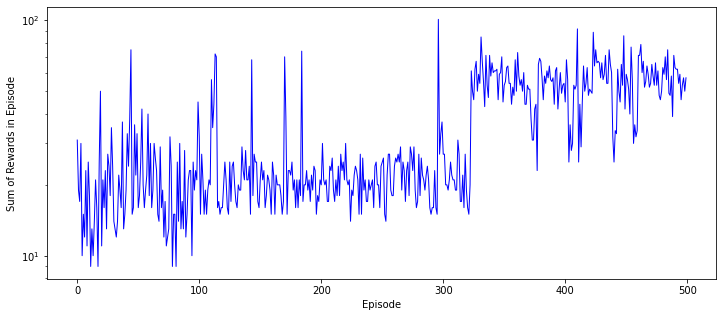

55.0

In [40]:
env=gym.make('CartPole-v1',render_mode='human')
(state,_)=env.reset()
#env.render()
#env.close()

# here define the parameters for state discretization
upperBounds=env.observation_space.high
lowerBounds=env.observation_space.low
cartVelocityMin=-3
cartVelocityMax=3
poleAngleVelocityMin=-10
poleAngleVelocityMax=10
upperBounds[1]=cartVelocityMax
upperBounds[3]=poleAngleVelocityMax
lowerBounds[1]=cartVelocityMin
lowerBounds[3]=poleAngleVelocityMin

numberOfBinsPosition=10
numberOfBinsVelocity=10
numberOfBinsAngle=10
numberOfBinsAngleVelocity=10
numberOfBins=[numberOfBinsPosition,numberOfBinsVelocity,numberOfBinsAngle,numberOfBinsAngleVelocity]
# define the parameters
numberEpisodes=500
# create an object
Q1=Q(env=env,numberEpisodes = numberEpisodes,numberOfBins = numberOfBins,lowerBounds = lowerBounds,upperBounds = upperBounds)
# run the Q-Learning algorithm
Q1.simulateEpisodes()
# simulate the learned strategy
(obtainedRewardsOptimal,env1)=Q1.simulateLearnedPolicy()

plt.figure(figsize=(12, 5))
# plot the figure and adjust the plot parameters
plt.plot(Q1.sumRewardsEpisode,color='blue',linewidth=1)
plt.xlabel('Episode')
plt.ylabel('Sum of Rewards in Episode')
plt.yscale('log')
plt.savefig('convergence.png')
plt.show()

# close the environment
env1.close()
# get the sum of rewards
np.sum(obtainedRewardsOptimal)

# run this several times and compare with a random learning policy
# (obtainedRewardsOptimal,env1)=Q2.simulateLearnedPolicy()